In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import datetime as dt

In [3]:
def backfill(df):
    # function to backfill blank or null values based on nearest available value
    for col in df:
        df[col] = (df[col].replace(0, np.nan)
                                          #.groupby(df['symbol'])
                                          .transform(lambda x: x.ffill().bfill())
                                          .fillna(0))
    return df

In [4]:
def get_quarter(value):
    current_month = float(value.split('-')[1])
    if current_month <= 3:
        return 'Q1'
    elif current_month <= 6:
        return 'Q2'
    elif current_month <= 9:
        return 'Q3'
    else: 
        return 'Q4'

In [5]:
def get_fmp_dataframe(url,attribute=None):
    response = requests.get(url)
    if attribute:
        return pd.DataFrame(response.json()[attribute])
    else:
        return pd.DataFrame(response.json())

In [6]:
def get_data(ticker):

    apikey = 'ed422f5ab8a52bef7a04a8d39de5129d'

    #Get historical stock price
    api_url5 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2019-02-01&to=2024-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_2 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2014-02-01&to=2019-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_3 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2009-02-01&to=2014-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_4 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=2004-02-01&to=2009-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"
    api_url5_5 = "https://financialmodelingprep.com/api/v3/historical-price-full/PLD?from=1999-02-01&to=2004-01-31&apikey=ed422f5ab8a52bef7a04a8d39de5129d"

    df5_1 = get_fmp_dataframe(api_url5,"historical")
    df5_2 = get_fmp_dataframe(api_url5_2,"historical")
    df5_3 = get_fmp_dataframe(api_url5_3,"historical")
    df5_4 = get_fmp_dataframe(api_url5_4,"historical")
    df5_5 = get_fmp_dataframe(api_url5_5,"historical")

    df5 = pd.concat([df5_1,df5_2,df5_3,df5_4,df5_5])
    
    #add quarters
    df5['period'] = df5['date'].apply(lambda x: get_quarter(x))
    #add year
    df5['calendarYear'] = df5['date'].apply(lambda x: x.split('-')[0])
    historicalStockPrice = backfill(df5)


    # Get Income Statement Data
    api_url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker}?period=quarter&apikey={apikey}'
    response = requests.get(api_url)
    df = pd.DataFrame(response.json())
    # Join Income Statement
    incomeStatement = backfill(df.drop(columns=['date'],axis=1))
    merge1 = pd.merge(historicalStockPrice, incomeStatement[incomeStatement.columns.difference(historicalStockPrice.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Balance Sheet Data
    api_url2 = f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker}?period=quarter&apikey={apikey}'
    response2 = requests.get(api_url2)
    df2 = pd.DataFrame(response2.json())
    # Join Balance Sheet
    balanceSheet = backfill(df2.drop(columns=['date'],axis=1))
    merge2 = pd.merge(merge1, balanceSheet[balanceSheet.columns.difference(merge1.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Cashflow Statement
    api_url3 = f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker}?period=quarter&apikey={apikey}'
    response3 = requests.get(api_url3)
    df3 = pd.DataFrame(response3.json())
    # Join Cash Flow Statement
    cashFlowStatement = backfill(df3.drop(columns=['date'],axis=1))
    merge3 = pd.merge(merge2, cashFlowStatement[cashFlowStatement.columns.difference(merge2.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])


    # Get Financial Statement Analysis
    api_url4 = f'https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?period=quarter&apikey={apikey}'
    response4 = requests.get(api_url4)
    df4 = pd.DataFrame(response4.json())
    # Join Financial Analysis
    FSA = backfill(df4.drop(columns=['date'],axis=1))
    merge4 = pd.merge(merge3, FSA[FSA.columns.difference(merge3.columns).tolist()+['period','calendarYear']],  how='left', on=['period','calendarYear'])
    
    merge4['date'] = pd.to_datetime(merge4['date'])
    
    return merge4



In [7]:
PLD = get_data('PLD')

In [8]:
PLD

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,...,returnOnTangibleAssets,revenuePerShare,roe,roic,salesGeneralAndAdministrativeToRevenue,shareholdersEquityPerShare,stockBasedCompensationToRevenue,tangibleAssetValue,tangibleBookValuePerShare,workingCapital
0,2024-01-19,126.92,128.870,126.060,128.44,128.44,3558857,3555913,1.52,1.20000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-18,126.79,127.250,124.665,126.26,126.26,4062956,4062900,-0.53,-0.41801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-17,127.94,129.535,125.370,126.86,126.86,3912969,3912900,-1.08,-0.84415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-16,130.27,131.525,129.170,129.97,129.97,4001192,4001200,-0.30,-0.23029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-12,132.65,132.970,130.595,131.55,131.55,2380625,2380600,-1.10,-0.82925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6278,1999-02-05,21.94,21.940,21.750,21.81,8.22,29500,29500,-0.13,-0.59253,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6279,1999-02-04,21.94,22.000,21.880,21.94,8.27,100600,100600,-0.13,-0.59253,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6280,1999-02-03,22.06,22.060,21.940,22.00,8.29,33400,33400,-0.06,-0.27199,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6281,1999-02-02,21.94,22.060,21.940,22.06,8.32,80600,80600,0.12,0.54695,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0


In [9]:
FNER_NAREIT_index = pd.read_csv('^FNER.csv')
FNER_NAREIT_index['Date'] = pd.to_datetime(FNER_NAREIT_index['Date'])
FNER_NAREIT_index

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-13,448.820007,449.019989,444.589996,448.260010,448.260010,0.0
1,2012-01-16,449.880005,449.880005,449.880005,449.880005,449.880005,0.0
2,2012-01-17,449.880005,456.070007,449.880005,455.899994,455.899994,0.0
3,2012-01-18,453.089996,457.380005,453.040009,456.000000,456.000000,0.0
4,2012-01-19,456.589996,459.619995,456.160004,459.109985,459.109985,0.0
...,...,...,...,...,...,...,...
3027,2024-01-10,752.059998,756.380005,751.250000,755.260010,755.260010,0.0
3028,2024-01-11,753.679993,753.679993,743.510010,746.849976,746.849976,0.0
3029,2024-01-12,746.750000,756.150024,746.750000,752.989990,752.989990,0.0
3030,2024-01-15,746.750000,756.150024,746.750000,751.750000,751.750000,0.0


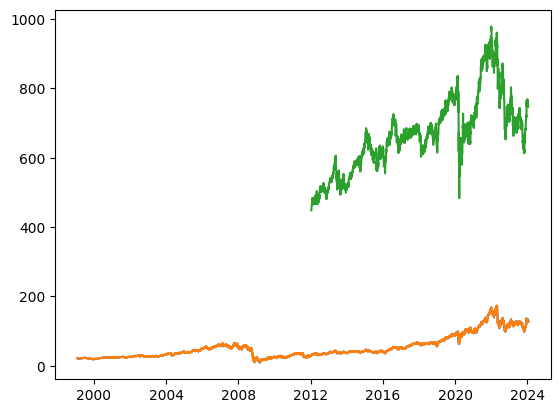

In [10]:
plt.plot(PLD['date'],PLD['close']);
plt.plot(PLD['date'],PLD['open']);
plt.plot(FNER_NAREIT_index['Date'],FNER_NAREIT_index['Open']);

In [11]:
import yfinance as yf

In [12]:
FNER_raw = yf.Ticker("^FNER")

In [13]:
FNER =  pd.DataFrame(FNER_raw.history(period="Max"))
FNER.reset_index(inplace=True)

In [14]:
FNER

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-01-12 00:00:00+00:00,451.559998,451.869995,445.859985,446.269989,0,0.0,0.0
1,2012-01-13 00:00:00+00:00,448.820007,449.019989,444.589996,448.260010,0,0.0,0.0
2,2012-01-16 00:00:00+00:00,449.880005,449.880005,449.880005,449.880005,0,0.0,0.0
3,2012-01-17 00:00:00+00:00,449.880005,456.070007,449.880005,455.899994,0,0.0,0.0
4,2012-01-18 00:00:00+00:00,453.089996,457.380005,453.040009,456.000000,0,0.0,0.0
...,...,...,...,...,...,...,...,...
3000,2024-01-15 00:00:00+00:00,746.750000,756.150024,746.750000,751.750000,0,0.0,0.0
3001,2024-01-16 00:00:00+00:00,751.750000,751.750000,745.320007,745.960022,0,0.0,0.0
3002,2024-01-17 00:00:00+00:00,746.729980,746.729980,725.049988,727.820007,0,0.0,0.0
3003,2024-01-18 00:00:00+00:00,732.570007,734.950012,722.809998,726.320007,0,0.0,0.0


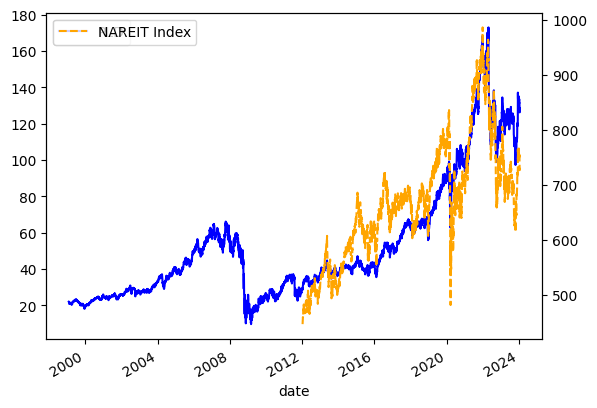

In [15]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
PLD.plot(x="date",y="close",ax=ax,color='blue',label='PLD');
FNER.plot(x="Date",y="Close",ax=ax2, ls="--", color="orange",label='NAREIT Index');

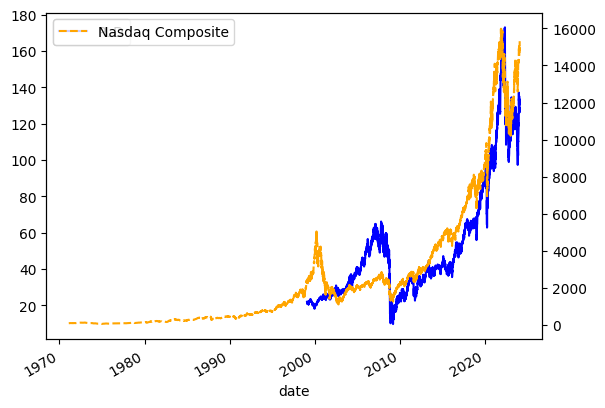

In [16]:
NASDAQ_Composite_raw = yf.Ticker("^IXIC")
IXIC =  pd.DataFrame(NASDAQ_Composite_raw.history(period="Max"))
IXIC.reset_index(inplace=True)


fig, ax = plt.subplots()
ax2 = ax.twinx()
PLD.plot(x="date",y="close",ax=ax,color='blue',label='PLD');
IXIC.plot(x="Date",y="Close",ax=ax2, ls="--", color="orange",label='Nasdaq Composite');

In [17]:
PLD

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,...,returnOnTangibleAssets,revenuePerShare,roe,roic,salesGeneralAndAdministrativeToRevenue,shareholdersEquityPerShare,stockBasedCompensationToRevenue,tangibleAssetValue,tangibleBookValuePerShare,workingCapital
0,2024-01-19,126.92,128.870,126.060,128.44,128.44,3558857,3555913,1.52,1.20000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-18,126.79,127.250,124.665,126.26,126.26,4062956,4062900,-0.53,-0.41801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-17,127.94,129.535,125.370,126.86,126.86,3912969,3912900,-1.08,-0.84415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-16,130.27,131.525,129.170,129.97,129.97,4001192,4001200,-0.30,-0.23029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-12,132.65,132.970,130.595,131.55,131.55,2380625,2380600,-1.10,-0.82925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6278,1999-02-05,21.94,21.940,21.750,21.81,8.22,29500,29500,-0.13,-0.59253,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6279,1999-02-04,21.94,22.000,21.880,21.94,8.27,100600,100600,-0.13,-0.59253,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6280,1999-02-03,22.06,22.060,21.940,22.00,8.29,33400,33400,-0.06,-0.27199,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0
6281,1999-02-02,21.94,22.060,21.940,22.06,8.32,80600,80600,0.12,0.54695,...,0.007578,1.274078,0.015903,0.029531,0.037163,20.482704,0.031496,2.086393e+09,24.260102,33312000.0


In [31]:
x_train = np.array(PLD['date'].map(dt.datetime.toordinal),dtype=np.float32)
x_train = x_train.reshape(-1,1)
y_train = np.array(PLD['close'],dtype=np.float32)
y_train = y_train.reshape(-1,1)

Single Linear Regression

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample data
X = torch.tensor(x_train, dtype=torch.float32)
Y = torch.tensor(y_train, dtype=torch.float32)

# Normalizing data
X_mean, X_std = X.mean(), X.std()
Y_mean, Y_std = Y.mean(), Y.std()

X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

# Reshaping data to fit the model
X_norm = X_norm.view(-1, 1)
Y_norm = Y_norm.view(-1, 1)

# Linear regression model
model = nn.Linear(1, 1)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)  # Lower learning rate

# Training the model
epochs = 1000
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(X_norm)

    # Compute loss
    loss = criterion(Y_pred, Y_norm)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Testing the model
predicted = model(X_norm).detach().numpy() * Y_std.numpy() + Y_mean.numpy() 
print(predicted)

Epoch 1/1000, Loss: 1.197727084159851
Epoch 101/1000, Loss: 0.9334099292755127
Epoch 201/1000, Loss: 0.7562926411628723
Epoch 301/1000, Loss: 0.6376071572303772
Epoch 401/1000, Loss: 0.5580769181251526
Epoch 501/1000, Loss: 0.5047842264175415
Epoch 601/1000, Loss: 0.46907302737236023
Epoch 701/1000, Loss: 0.4451431632041931
Epoch 801/1000, Loss: 0.4291079342365265
Epoch 901/1000, Loss: 0.4183627963066101
[[90.695496]
 [90.687225]
 [90.678955]
 ...
 [15.284092]
 [15.275818]
 [15.267548]]


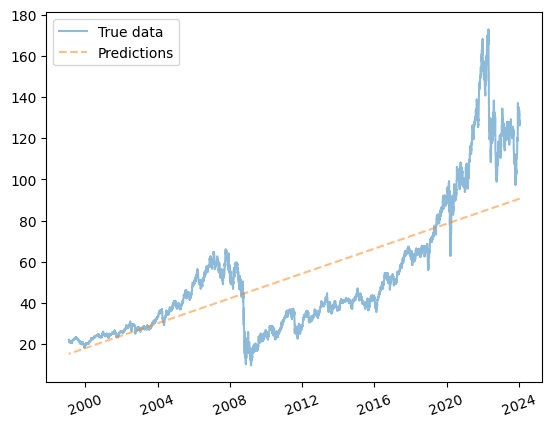

In [20]:
x_train_date = list(map(dt.date.fromordinal,x_train[:,0].astype(int)))
plt.clf()
plt.plot(x_train_date, y_train, '-', label='True data', alpha=0.5)
plt.plot(x_train_date, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.xticks(rotation=20)
plt.show()

In [37]:
recasted_PLD = PLD
#recasted_PLD['date'] = recasted_PLD['date'].map(dt.datetime.toordinal)
x_train = np.array(recasted_PLD[['date','open']],dtype=np.float32)
x_train = x_train.reshape(-1,2)
y_train = np.array(recasted_PLD['close'],dtype=np.float32)
y_train = y_train.reshape(-1,1)

In [38]:
x_train

array([[7.38904e+05, 1.26920e+02],
       [7.38903e+05, 1.26790e+02],
       [7.38902e+05, 1.27940e+02],
       ...,
       [7.29788e+05, 2.20600e+01],
       [7.29787e+05, 2.19400e+01],
       [7.29786e+05, 2.20000e+01]], dtype=float32)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample data
# Assuming x_train is a 2D array with two features
X = torch.tensor(x_train, dtype=torch.float32)
Y = torch.tensor(y_train, dtype=torch.float32)

# Normalizing data
X_mean, X_std = X.mean(0), X.std(0)  # Mean and std for each feature
Y_mean, Y_std = Y.mean(), Y.std()

X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

# No need to reshape X_norm as it should already be of shape [n_samples, n_features]

Y_norm = Y_norm.view(-1, 1)  # Reshaping Y_norm

# Linear regression model
model = nn.Linear(2, 1)  # Change from 1 to 2 input features

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training the model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    Y_pred = model(X_norm)
    loss = criterion(Y_pred, Y_norm)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Testing the model
predicted = model(X_norm).detach().numpy() * Y_std.numpy() + Y_mean.numpy() 
print(predicted)

Epoch 1/1000, Loss: 0.66152423620224
Epoch 101/1000, Loss: 0.36857786774635315
Epoch 201/1000, Loss: 0.21935121715068817
Epoch 301/1000, Loss: 0.14169852435588837
Epoch 401/1000, Loss: 0.09993492811918259
Epoch 501/1000, Loss: 0.07635489851236343
Epoch 601/1000, Loss: 0.062135420739650726
Epoch 701/1000, Loss: 0.05285198986530304
Epoch 801/1000, Loss: 0.046265799552202225
Epoch 901/1000, Loss: 0.04122890904545784
[[121.639175]
 [121.54385 ]
 [122.3535  ]
 ...
 [ 16.407936]
 [ 16.319683]
 [ 16.358696]]


In [ ]:
# Testing the model
predicted = model(X_normalized).detach().numpy() #* Y_std.numpy() + Y_mean.numpy() 
print(predicted)

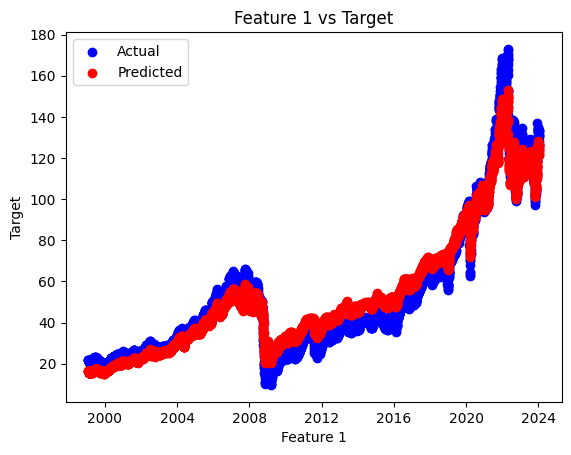

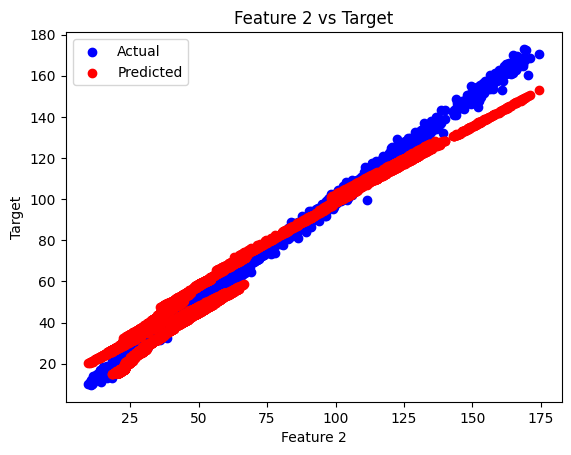

In [45]:
import matplotlib.pyplot as plt

# Assuming x_train is a 2D array with two features and y_train is the target array

# Converting predictions to numpy for easy plotting
predicted_numpy = predicted.squeeze()

# Plot for Feature 1
x_train_date = list(map(dt.date.fromordinal,x_train[:, 0].astype(int)))
plt.scatter(x_train_date, y_train, label='Actual', color='blue')
plt.scatter(x_train_date, predicted_numpy, label='Predicted', color='red')
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Feature 1 vs Target')
plt.legend()
plt.show()

# Plot for Feature 2
plt.scatter(x_train[:, 1], y_train, label='Actual', color='blue')
plt.scatter(x_train[:, 1], predicted_numpy, label='Predicted', color='red')
plt.xlabel('Feature 2')
plt.ylabel('Target')
plt.title('Feature 2 vs Target')
plt.legend()
plt.show()

In [23]:
Y

tensor([[128.4400],
        [126.2600],
        [126.8600],
        ...,
        [ 22.0000],
        [ 22.0600],
        [ 22.0600]])